In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.171:35769,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.171:35769' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [9]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [10]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [11]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [12]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [13]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [14]:
# Load zeta data
VarToKeep = ['u_eastward','v_northward','z_rho0','temp','zeta','salt']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
# truth = truth.drop('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)

truth_S = truth.sel(ocean_time=time_range_to_load_S)
truth_N = truth.sel(ocean_time=time_range_to_load_N)
truth_S.load(), print('done, loaded ~'+str(truth_S.nbytes/1024/1024/1024)+'G')
truth_N.load(), print('done, loaded ~'+str(truth_N.nbytes/1024/1024/1024)+'G')



VarToKeep = ['u_eastward','v_northward','z_rho0','temp','salt','zeta']#,'dA','dx','dy','dz']

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

# OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
# OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
# OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
# OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')

truth["z_w0"] = truth_bu.z_w.mean(dim='ocean_time')
OSSE_SSHSST["z_w0"] = OSSE_SSHSST_bu.z_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT["z_w0"] = OSSE_SSHSST_XBT_bu.z_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["z_w0"] = OSSE_SSHSST_XBT_N_bu.z_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["z_w0"] = OSSE_SSHSST_XBT_S_bu.z_w.mean(dim='ocean_time')

SSHSST_S = OSSE_SSHSST.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_N_S = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S_S = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_S)

SSHSST_N = OSSE_SSHSST.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N_N = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_S_N = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_N)

# SSHSST_S.load(), print('done, loaded ~'+str(SSHSST_S.nbytes/1024/1024/1024)+'G')
# SSHSST_N.load(), print('done, loaded ~'+str(SSHSST_N.nbytes/1024/1024/1024)+'G')

# SSHSST_XBT_S1.load(), print('done, loaded ~'+str(SSHSST_XBT_S1.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_N1.load(), print('done, loaded ~'+str(SSHSST_XBT_N1.nbytes/1024/1024/1024)+'G')

# SSHSST_XBT_N_S.load(), print('done, loaded ~'+str(SSHSST_XBT_N_S.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_N_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N_N.nbytes/1024/1024/1024)+'G')

# SSHSST_XBT_S_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S_S.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_S_N.load(), print('done, loaded ~'+str(SSHSST_XBT_S_N.nbytes/1024/1024/1024)+'G')



# truth_eddyN = truth.sel(ocean_time=time_range_to_load_eddyN)
# truth_eddyN.load(), print('done, loaded ~'+str(truth_eddyN.nbytes/1024/1024/1024)+'G')
# SSHSST_eddyN = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddyN)
# SSHSST_XBT_eddyN = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddyN)
# SSHSST_XBT_N_eddyN = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddyN)
# SSHSST_XBT_S_eddyN = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddyN)
# SSHSST_eddyN.load(), print('done, loaded ~'+str(SSHSST_eddyN.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_eddyN.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_N_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddyN.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_S_eddyN.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddyN.nbytes/1024/1024/1024)+'G')




# truth_eddy2 = truth.sel(ocean_time=time_range_to_load_eddy2)
# truth_eddy2.load(), print('done, loaded ~'+str(truth_eddy2.nbytes/1024/1024/1024)+'G')
# SSHSST_eddy2 = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddy2)
# SSHSST_XBT_eddy2 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddy2)
# SSHSST_XBT_N_eddy2 = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddy2)
# SSHSST_XBT_S_eddy2 = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddy2)
# SSHSST_eddy2.load(), print('done, loaded ~'+str(SSHSST_eddy2.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_eddy2.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_N_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddy2.nbytes/1024/1024/1024)+'G')
# SSHSST_XBT_S_eddy2.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddy2.nbytes/1024/1024/1024)+'G')


truth_eddy3 = truth.sel(ocean_time=time_range_to_load_eddy3)
truth_eddy3.load(), print('done, loaded ~'+str(truth_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_eddy3 = OSSE_SSHSST.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_eddy3 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_N_eddy3 = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_XBT_S_eddy3 = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_eddy3)
SSHSST_eddy3.load(), print('done, loaded ~'+str(SSHSST_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_N_eddy3.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_eddy3.load(), print('done, loaded ~'+str(SSHSST_XBT_S_eddy3.nbytes/1024/1024/1024)+'G')

done, loaded ~0.12784158438444138G
done, loaded ~0.12784158438444138G
done, loaded ~0.23512577265501022G
done, loaded ~0.25439833849668503G
done, loaded ~0.25439833849668503G
done, loaded ~0.25439833849668503G
done, loaded ~0.25439833849668503G


(<xarray.Dataset>
 Dimensions:      (ocean_time: 2, s_rho: 30, eta_rho: 317, xi_rho: 272, s_w: 31)
 Coordinates:
     z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time   (ocean_time) datetime64[ns] 2012-03-11 2012-03-16
     z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -0.9809
   * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 25.1
     salt         (ocean_time, s_rho, e

In [15]:

# truth_eddy3["temp250"] = horizontalSectionROMS(grid, truth_eddy3.temp, np.array([-250]))
# truth_eddy3["v250"] = horizontalSectionROMS(grid, truth_eddy3.v_northward, np.array([-250]))
# truth_eddy3["u250"] = horizontalSectionROMS(grid, truth_eddy3.u_eastward, np.array([-250]))


In [16]:


etaTransect=60
xx_60=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_60=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_60.load(),print('done')
etaTransect=40
xx_40=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_40=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_40.load(),print('done')
etaTransect=55
xx_55=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_55=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_55.load(),print('done')
etaTransect=47
xx_47=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_47=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_47.load(),print('done')
etaTransect=35
xx_35=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_35=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_35.load(),print('done')



etaTransect=110
xx_110=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_110=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_110.load(),print('done')
etaTransect=115
xx_115=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_115=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_115.load(),print('done')
etaTransect=120
xx_120=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_120=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_120.load(),print('done')




done
done
done
done
done
done
done
done


(<xarray.DataArray 'z_rho0' (s_rho: 30, xi_rho: 272)>
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.45028145e+03, -4.44502387e+03, -4.44502387e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.18001315e+03, -4.17507607e+03, -4.17507607e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.68420532e+03, -3.67987708e+03, -3.67987708e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.04693507e+01, -1.04654574e+01, -1.04654577e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.66414891e+00, -5.66100291e+00, -5.66100317e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.59526814e+00, -1.59262792e+00, -1.59262818e+00]])
 Coordinates:
     z_rho0   (s_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... -1.595 -1.593 -1.593
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lo

In [17]:
import seawater as sw

def calc_N2_atLocation(ds,ee,xx):
    s = ds.salt.mean(dim='ocean_time').isel(eta_rho=ee,xi_rho=xx)
    t = ds.temp.mean(dim='ocean_time').isel(eta_rho=ee,xi_rho=xx)
    la= ds.lat_rho.isel(eta_rho=ee,xi_rho=xx)
    p = sw.eos80.pres(-ds.z_rho0.isel(eta_rho=ee,xi_rho=xx),la)
    out=sw.geostrophic.bfrq(s,t,p,la)[0]
    return out,ds.z_w0.isel(eta_rho=ee,xi_rho=xx)[1:-1]

# truth_eddy3_n2 = sw.geostrophic.bfrq(truth_eddy3.salt.isel(eta_rho=60).mean(dim='ocean_time'),truth_eddy3.temp.isel(eta_rho=60).mean(dim='ocean_time'),-zz_60)[0]
# truth_eddy3_n2_extract = truth_eddy3_n2[:,125]
# truth_eddy3_z_w_extract = truth_bu.z_w.mean(dim='ocean_time').isel(eta_rho=60,xi_rho=125)[1:-1]



In [18]:
# calculate N2
truth_eddy3_n2_extract_1,truth_eddy3_z_w_extract_1 = calc_N2_atLocation(truth_eddy3,ee=60,xx=123)
truth_eddy3_n2_extract_2,truth_eddy3_z_w_extract_2 = calc_N2_atLocation(truth_eddy3,ee=120,xx=155)
truth_eddy3_n2_extract_3,truth_eddy3_z_w_extract_3 = calc_N2_atLocation(truth_eddy3,ee=60,xx=240)
truth_eddy3_n2_extract_4,truth_eddy3_z_w_extract_4 = calc_N2_atLocation(truth_eddy3,ee=120,xx=240)

SSHSST_eddy3_n2_extract_1,SSHSST_eddy3_z_w_extract_1 = calc_N2_atLocation(SSHSST_eddy3,ee=40,xx=140)
SSHSST_eddy3_n2_extract_2,SSHSST_eddy3_z_w_extract_2 = calc_N2_atLocation(SSHSST_eddy3,ee=115,xx=165)
SSHSST_eddy3_n2_extract_3,SSHSST_eddy3_z_w_extract_3 = calc_N2_atLocation(SSHSST_eddy3,ee=40,xx=240)
SSHSST_eddy3_n2_extract_4,SSHSST_eddy3_z_w_extract_4 = calc_N2_atLocation(SSHSST_eddy3,ee=115,xx=240)

SSHSST_XBT_N_eddy3_n2_extract_1,SSHSST_XBT_N_eddy3_z_w_extract_1 = calc_N2_atLocation(SSHSST_XBT_N_eddy3,ee=55,xx=128)
SSHSST_XBT_N_eddy3_n2_extract_2,SSHSST_XBT_N_eddy3_z_w_extract_2 = calc_N2_atLocation(SSHSST_XBT_N_eddy3,ee=115,xx=160)
SSHSST_XBT_N_eddy3_n2_extract_3,SSHSST_XBT_N_eddy3_z_w_extract_3 = calc_N2_atLocation(SSHSST_XBT_N_eddy3,ee=55,xx=240)
SSHSST_XBT_N_eddy3_n2_extract_4,SSHSST_XBT_N_eddy3_z_w_extract_4 = calc_N2_atLocation(SSHSST_XBT_N_eddy3,ee=115,xx=240)

SSHSST_XBT_S_eddy3_n2_extract_1,SSHSST_XBT_S_eddy3_z_w_extract_1 = calc_N2_atLocation(SSHSST_XBT_S_eddy3,ee=53,xx=132)
SSHSST_XBT_S_eddy3_n2_extract_2,SSHSST_XBT_S_eddy3_z_w_extract_2 = calc_N2_atLocation(SSHSST_XBT_S_eddy3,ee=115,xx=157)
SSHSST_XBT_S_eddy3_n2_extract_3,SSHSST_XBT_S_eddy3_z_w_extract_3 = calc_N2_atLocation(SSHSST_XBT_S_eddy3,ee=53,xx=240)
SSHSST_XBT_S_eddy3_n2_extract_4,SSHSST_XBT_S_eddy3_z_w_extract_4 = calc_N2_atLocation(SSHSST_XBT_S_eddy3,ee=115,xx=240)

SSHSST_XBT_eddy3_n2_extract_1,SSHSST_XBT_eddy3_z_w_extract_1 = calc_N2_atLocation(SSHSST_XBT_eddy3,ee=35,xx=140)
SSHSST_XBT_eddy3_n2_extract_2,SSHSST_XBT_eddy3_z_w_extract_2 = calc_N2_atLocation(SSHSST_XBT_eddy3,ee=110,xx=158)
SSHSST_XBT_eddy3_n2_extract_3,SSHSST_XBT_eddy3_z_w_extract_3 = calc_N2_atLocation(SSHSST_XBT_eddy3,ee=35,xx=240)
SSHSST_XBT_eddy3_n2_extract_4,SSHSST_XBT_eddy3_z_w_extract_4 = calc_N2_atLocation(SSHSST_XBT_eddy3,ee=110,xx=240)

Testing of the interpolation scheme

In [19]:
# interp to equidistant depths
from scipy import interpolate

ii = interpolate.interp1d(truth_eddy3_z_w_extract_1.values,truth_eddy3_n2_extract_1.T)
n2_interp = (ii(np.arange(-4500,0,10))).T


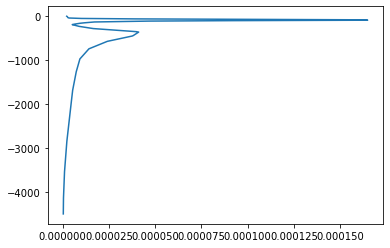

In [20]:
plt.plot(n2_interp,np.arange(-4500,0,10))

In [21]:
# truth_N2profiles.coords["depth_i"] = np.arange(-4500,0,10)

In [22]:
# np.vstack([n2_interp,n2_interp]).shape

In [23]:
# truth_N2profiles["n2_i"] = ({"depth_i","loc"},np.vstack([n2_interp,n2_interp]))

In [24]:
# truth_N2profiles.n2_i.isel(loc=0).plot(y='depth_i')
# truth_N2profiles.n2.isel(loc=0).plot(y='depth',marker='x',linewidth=0)
# plt.show()


Finish testing of interpolation - now do it for realz

In [25]:
# interp to equidistant depths
from scipy import interpolate

interp_to_array = np.arange(-4500,0,5)

#truth
ii = interpolate.interp1d(truth_eddy3_z_w_extract_1.values,truth_eddy3_n2_extract_1.T)
truth_n2_interp_1 = (ii(interp_to_array)).T
ii = interpolate.interp1d(truth_eddy3_z_w_extract_2.values,truth_eddy3_n2_extract_2.T)
truth_n2_interp_2 = (ii(interp_to_array)).T
ii = interpolate.interp1d(truth_eddy3_z_w_extract_3.values,truth_eddy3_n2_extract_3.T)
truth_n2_interp_3 = (ii(interp_to_array)).T
ii = interpolate.interp1d(truth_eddy3_z_w_extract_4.values,truth_eddy3_n2_extract_4.T,fill_value='extrapolate')
truth_n2_interp_4 = (ii(interp_to_array)).T
#sshsst
ii = interpolate.interp1d(SSHSST_eddy3_z_w_extract_1.values,SSHSST_eddy3_n2_extract_1.T)
SSHSST_n2_interp_1 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_eddy3_z_w_extract_2.values,SSHSST_eddy3_n2_extract_2.T)
SSHSST_n2_interp_2 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_eddy3_z_w_extract_3.values,SSHSST_eddy3_n2_extract_3.T)
SSHSST_n2_interp_3 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_eddy3_z_w_extract_4.values,SSHSST_eddy3_n2_extract_4.T,fill_value='extrapolate')
SSHSST_n2_interp_4 = (ii(interp_to_array)).T
#sshsst_xbt_n
ii = interpolate.interp1d(SSHSST_XBT_N_eddy3_z_w_extract_1.values,SSHSST_XBT_N_eddy3_n2_extract_1.T)
SSHSST_XBT_N_n2_interp_1 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_N_eddy3_z_w_extract_2.values,SSHSST_XBT_N_eddy3_n2_extract_2.T)
SSHSST_XBT_N_n2_interp_2 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_N_eddy3_z_w_extract_3.values,SSHSST_XBT_N_eddy3_n2_extract_3.T)
SSHSST_XBT_N_n2_interp_3 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_N_eddy3_z_w_extract_4.values,SSHSST_XBT_N_eddy3_n2_extract_4.T,fill_value='extrapolate')
SSHSST_XBT_N_n2_interp_4 = (ii(interp_to_array)).T
#sshsst_xbt_n
ii = interpolate.interp1d(SSHSST_XBT_S_eddy3_z_w_extract_1.values,SSHSST_XBT_S_eddy3_n2_extract_1.T)
SSHSST_XBT_S_n2_interp_1 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_S_eddy3_z_w_extract_2.values,SSHSST_XBT_S_eddy3_n2_extract_2.T)
SSHSST_XBT_S_n2_interp_2 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_S_eddy3_z_w_extract_3.values,SSHSST_XBT_S_eddy3_n2_extract_3.T,fill_value='extrapolate')
SSHSST_XBT_S_n2_interp_3 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_S_eddy3_z_w_extract_4.values,SSHSST_XBT_S_eddy3_n2_extract_4.T,fill_value='extrapolate')
SSHSST_XBT_S_n2_interp_4 = (ii(interp_to_array)).T
#sshsst_xbt
ii = interpolate.interp1d(SSHSST_XBT_eddy3_z_w_extract_1.values,SSHSST_XBT_eddy3_n2_extract_1.T)
SSHSST_XBT_n2_interp_1 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_eddy3_z_w_extract_2.values,SSHSST_XBT_eddy3_n2_extract_2.T)
SSHSST_XBT_n2_interp_2 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_eddy3_z_w_extract_3.values,SSHSST_XBT_eddy3_n2_extract_3.T)
SSHSST_XBT_n2_interp_3 = (ii(interp_to_array)).T
ii = interpolate.interp1d(SSHSST_XBT_eddy3_z_w_extract_4.values,SSHSST_XBT_eddy3_n2_extract_4.T,fill_value='extrapolate')
SSHSST_XBT_n2_interp_4 = (ii(interp_to_array)).T

In [26]:
SSHSST_XBT_N_eddy3_z_w_extract_3.values

array([-4.50852450e+03, -4.10683983e+03, -3.50291793e+03, -2.82645203e+03,
       -2.19675032e+03, -1.67315960e+03, -1.26584045e+03, -9.60429316e+02,
       -7.35391003e+02, -5.70326954e+02, -4.48735726e+02, -3.58229771e+02,
       -2.89864097e+02, -2.37308736e+02, -1.96126877e+02, -1.63218405e+02,
       -1.36415268e+02, -1.14195917e+02, -9.54868084e+01, -7.95253382e+01,
       -6.57653351e+01, -5.38117889e+01, -4.33756157e+01, -3.42421870e+01,
       -2.62493647e+01, -1.92721603e+01, -1.32120554e+01, -7.98964213e+00,
       -3.53965083e+00])

In [27]:
#Now save to ds

# truth
data_vars = {'n2':(['z_w0_','loc'],(np.hstack([truth_eddy3_n2_extract_1,truth_eddy3_n2_extract_2,truth_eddy3_n2_extract_3,truth_eddy3_n2_extract_4])),
                   {'units':'s-2',
                    'long_name':'Brunt-Vaisala frequency squared'})}
coords = {'depth':(['z_w0_','loc'],(np.vstack([truth_eddy3_z_w_extract_1.values,truth_eddy3_z_w_extract_2.values,truth_eddy3_z_w_extract_3.values,truth_eddy3_z_w_extract_4.values]).T) ),
          'loc_id':(['loc'],["south","high-energy-region","south-fareast","high-energy-region-fareast"])}
truth_N2profiles = xr.Dataset(data_vars=data_vars,coords=coords)

# sshsst
data_vars = {'n2':(['z_w0_','loc'],(np.hstack([SSHSST_eddy3_n2_extract_1,SSHSST_eddy3_n2_extract_2,SSHSST_eddy3_n2_extract_3,SSHSST_eddy3_n2_extract_4])),
                   {'units':'s-2',
                    'long_name':'Brunt-Vaisala frequency squared'})}
coords = {'depth':(['z_w0_','loc'],(np.vstack([SSHSST_eddy3_z_w_extract_1.values,SSHSST_eddy3_z_w_extract_2.values,SSHSST_eddy3_z_w_extract_3.values,SSHSST_eddy3_z_w_extract_4.values]).T) ),
          'loc_id':(['loc'],["south","high-energy-region","south-fareast","high-energy-region-fareast"])}
SSHSST_N2profiles = xr.Dataset(data_vars=data_vars,coords=coords)


# sshsst_xbt_n
data_vars = {'n2':(['z_w0_','loc'],(np.hstack([SSHSST_XBT_N_eddy3_n2_extract_1,SSHSST_XBT_N_eddy3_n2_extract_2,SSHSST_XBT_N_eddy3_n2_extract_3,SSHSST_XBT_N_eddy3_n2_extract_4])),
                   {'units':'s-2',
                    'long_name':'Brunt-Vaisala frequency squared'})}
coords = {'depth':(['z_w0_','loc'],(np.vstack([SSHSST_XBT_N_eddy3_z_w_extract_1.values,SSHSST_XBT_N_eddy3_z_w_extract_2.values,SSHSST_XBT_N_eddy3_z_w_extract_3.values,SSHSST_XBT_N_eddy3_z_w_extract_4.values]).T) ),
          'loc_id':(['loc'],["south","high-energy-region","south-fareast","high-energy-region-fareast"])}
SSHSST_XBT_N_N2profiles = xr.Dataset(data_vars=data_vars,coords=coords)


# sshsst_xbt_s
data_vars = {'n2':(['z_w0_','loc'],(np.hstack([SSHSST_XBT_S_eddy3_n2_extract_1,SSHSST_XBT_S_eddy3_n2_extract_2,SSHSST_XBT_S_eddy3_n2_extract_3,SSHSST_XBT_S_eddy3_n2_extract_4])),
                   {'units':'s-2',
                    'long_name':'Brunt-Vaisala frequency squared'})}
coords = {'depth':(['z_w0_','loc'],(np.vstack([SSHSST_XBT_S_eddy3_z_w_extract_1.values,SSHSST_XBT_S_eddy3_z_w_extract_2.values,SSHSST_XBT_S_eddy3_z_w_extract_3.values,SSHSST_XBT_S_eddy3_z_w_extract_4.values]).T) ),
          'loc_id':(['loc'],["south","high-energy-region","south-fareast","high-energy-region-fareast"])}
SSHSST_XBT_S_N2profiles = xr.Dataset(data_vars=data_vars,coords=coords)


# sshsst_xbt
data_vars = {'n2':(['z_w0_','loc'],(np.hstack([SSHSST_XBT_eddy3_n2_extract_1,SSHSST_XBT_eddy3_n2_extract_2,SSHSST_XBT_eddy3_n2_extract_3,SSHSST_XBT_eddy3_n2_extract_4])),
                   {'units':'s-2',
                    'long_name':'Brunt-Vaisala frequency squared'})}
coords = {'depth':(['z_w0_','loc'],(np.vstack([SSHSST_XBT_eddy3_z_w_extract_1.values,SSHSST_XBT_eddy3_z_w_extract_2.values,SSHSST_XBT_eddy3_z_w_extract_3.values,SSHSST_XBT_eddy3_z_w_extract_4.values]).T) ),
          'loc_id':(['loc'],["south","high-energy-region","south-fareast","high-energy-region-fareast"])}
SSHSST_XBT_N2profiles = xr.Dataset(data_vars=data_vars,coords=coords)



In [28]:
# truth_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([truth_n2_interp_1,truth_n2_interp_2]))


In [29]:
#add interpolated values
truth_N2profiles.coords["depth_i"] = interp_to_array
SSHSST_N2profiles.coords["depth_i"] = interp_to_array
SSHSST_XBT_N_N2profiles.coords["depth_i"] = interp_to_array
SSHSST_XBT_S_N2profiles.coords["depth_i"] = interp_to_array
SSHSST_XBT_N2profiles.coords["depth_i"] = interp_to_array

truth_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([truth_n2_interp_1,truth_n2_interp_2,truth_n2_interp_3,truth_n2_interp_4]))
SSHSST_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([SSHSST_n2_interp_1,SSHSST_n2_interp_2,SSHSST_n2_interp_3,SSHSST_n2_interp_4]))
SSHSST_XBT_N_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([SSHSST_XBT_N_n2_interp_1,SSHSST_XBT_N_n2_interp_2,SSHSST_XBT_N_n2_interp_3,SSHSST_XBT_N_n2_interp_4]))
SSHSST_XBT_S_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([SSHSST_XBT_S_n2_interp_1,SSHSST_XBT_S_n2_interp_2,SSHSST_XBT_S_n2_interp_3,SSHSST_XBT_S_n2_interp_4]))
SSHSST_XBT_N2profiles["n2_i"] = (["depth_i","loc"],np.hstack([SSHSST_XBT_n2_interp_1,SSHSST_XBT_n2_interp_2,SSHSST_XBT_n2_interp_3,SSHSST_XBT_n2_interp_4]))

Text(0.5, -0.04, 'Brunt-Vaisala [$x10^{-4}$ s$^{-2}$]')

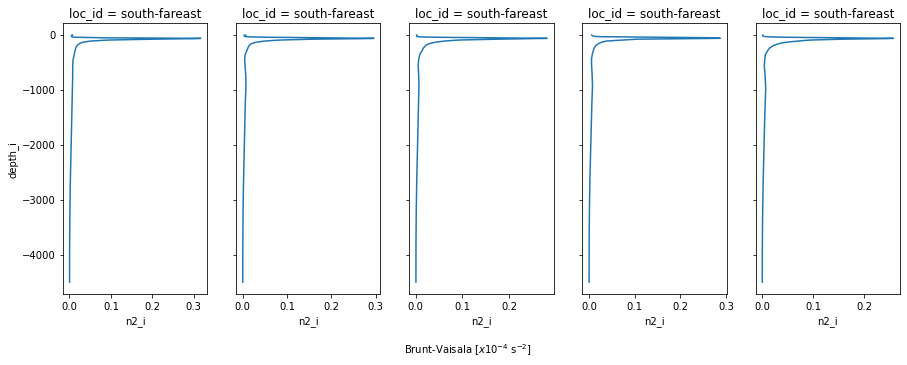

In [30]:
fig,ax=plt.subplots(ncols=5,figsize=[15,5],sharey=True)
(truth_N2profiles.n2_i/10e-4).isel(loc=2).plot(ax=ax[0],y='depth_i')
(SSHSST_N2profiles.n2_i/10e-4).isel(loc=2).plot(ax=ax[1],y='depth_i')
(SSHSST_XBT_N_N2profiles.n2_i/10e-4).isel(loc=2).plot(ax=ax[2],y='depth_i')
(SSHSST_XBT_S_N2profiles.n2_i/10e-4).isel(loc=2).plot(ax=ax[3],y='depth_i')
(SSHSST_XBT_N2profiles.n2_i/10e-4).isel(loc=2).plot(ax=ax[4],y='depth_i')
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[3].set_ylabel(None)
ax[4].set_ylabel(None)
fig.text(0.5, -0.04, 'Brunt-Vaisala [$x10^{-4}$ s$^{-2}$]', ha='center')


Text(0.5, -0.04, 'Brunt-Vaisala [$x10^{-4}$ s$^{-2}$]')

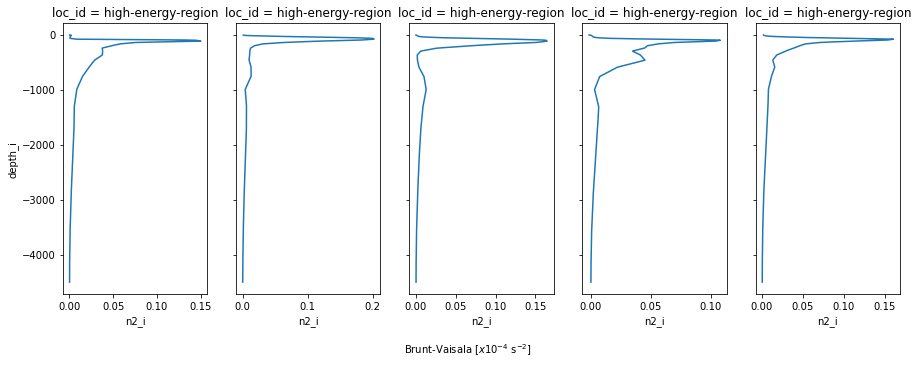

In [31]:
fig,ax=plt.subplots(ncols=5,figsize=[15,5],sharey=True)
(truth_N2profiles.n2_i/10e-4).isel(loc=1).plot(ax=ax[0],y='depth_i')
(SSHSST_N2profiles.n2_i/10e-4).isel(loc=1).plot(ax=ax[1],y='depth_i')
(SSHSST_XBT_N_N2profiles.n2_i/10e-4).isel(loc=1).plot(ax=ax[2],y='depth_i')
(SSHSST_XBT_S_N2profiles.n2_i/10e-4).isel(loc=1).plot(ax=ax[3],y='depth_i')
(SSHSST_XBT_N2profiles.n2_i/10e-4).isel(loc=1).plot(ax=ax[4],y='depth_i')
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
ax[3].set_ylabel(None)
ax[4].set_ylabel(None)
fig.text(0.5, -0.04, 'Brunt-Vaisala [$x10^{-4}$ s$^{-2}$]', ha='center')


In [32]:
# save to netcdf
Yes = 0
if Yes:
    truth_N2profiles.to_netcdf('truth_N2profiles.nc')
    SSHSST_N2profiles.to_netcdf('SSHSST_N2profiles.nc')
    SSHSST_XBT_N_N2profiles.to_netcdf('SSHSST_XBT_N_N2profiles.nc')
    SSHSST_XBT_S_N2profiles.to_netcdf('SSHSST_XBT_S_N2profiles.nc')
    SSHSST_XBT_N2profiles.to_netcdf('SSHSST_XBT_N2profiles.nc')

In [33]:
Continue=1
if Continue:
    print('great')
elif ~Continue:
        STOP

great


In [34]:
# load modes which I make in matlab
truth_modes = xr.load_dataset('../data/proc/truth_modes.nc')
sshsst_modes = xr.load_dataset('../data/proc/sshsst_modes.nc')
sshsst_xbt_n_modes = xr.load_dataset('../data/proc/sshsst_xbt_n_modes.nc')
sshsst_xbt_s_modes = xr.load_dataset('../data/proc/sshsst_xbt_s_modes.nc')
sshsst_xbt_modes = xr.load_dataset('../data/proc/sshsst_xbt_modes.nc')


In [35]:
# join those modes back into our ds
truth_N2profiles.coords["Mode"] = truth_modes.Mode.values
SSHSST_N2profiles.coords["Mode"] = sshsst_modes.Mode.values
SSHSST_XBT_N_N2profiles.coords["Mode"] = sshsst_xbt_n_modes.Mode.values
SSHSST_XBT_S_N2profiles.coords["Mode"] = sshsst_xbt_s_modes.Mode.values
SSHSST_XBT_N2profiles.coords["Mode"] = sshsst_xbt_modes.Mode.values

In [36]:
sshsst_modes

<xarray.Dataset>
Dimensions:         (Mode: 15, depth_i: 900)
Coordinates:
  * depth_i         (depth_i) float64 -4.5e+03 -4.495e+03 ... -10.0 -5.0
Dimensions without coordinates: Mode
Data variables:
    SSHSST_Phi_p_1  (Mode, depth_i) float64 0.9997 0.9997 ... 0.0642 0.06453
    SSHSST_Phi_p_2  (Mode, depth_i) float64 0.9997 0.9997 ... 0.05353 0.05384
    SSHSST_Phi_p_3  (Mode, depth_i) float64 0.9998 0.9998 ... 0.05216 0.05245
    SSHSST_Phi_p_4  (Mode, depth_i) float64 0.9998 0.9998 ... 0.04975 0.05

In [37]:
truth_N2profiles["phi_n"] =  xr.concat([truth_modes.truth_Phi_p_1,truth_modes.truth_Phi_p_2,truth_modes.truth_Phi_p_3,truth_modes.truth_Phi_p_4],"loc")
SSHSST_N2profiles["phi_n"] =  xr.concat([sshsst_modes.SSHSST_Phi_p_1,sshsst_modes.SSHSST_Phi_p_2,sshsst_modes.SSHSST_Phi_p_3,sshsst_modes.SSHSST_Phi_p_4],"loc")
SSHSST_XBT_N_N2profiles["phi_n"] =  xr.concat([sshsst_xbt_n_modes.SSHSST_XBT_N_Phi_p_1,sshsst_xbt_n_modes.SSHSST_XBT_N_Phi_p_2,sshsst_xbt_n_modes.SSHSST_XBT_N_Phi_p_3,sshsst_xbt_n_modes.SSHSST_XBT_N_Phi_p_4],"loc")
SSHSST_XBT_S_N2profiles["phi_n"] =  xr.concat([sshsst_xbt_s_modes.SSHSST_XBT_S_Phi_p_1,sshsst_xbt_s_modes.SSHSST_XBT_S_Phi_p_2,sshsst_xbt_s_modes.SSHSST_XBT_S_Phi_p_3,sshsst_xbt_s_modes.SSHSST_XBT_S_Phi_p_4],"loc")
SSHSST_XBT_N2profiles["phi_n"] =  xr.concat([sshsst_xbt_modes.SSHSST_XBT_Phi_p_1,sshsst_xbt_modes.SSHSST_XBT_Phi_p_2,sshsst_xbt_modes.SSHSST_XBT_Phi_p_3,sshsst_xbt_modes.SSHSST_XBT_Phi_p_4],"loc")

In [38]:
# normalise modes by max of each mode
DoIt=2

if DoIt==1: # normalise to have max = 1
    truth_N2profiles["phi_n"] = truth_N2profiles.phi_n/abs(truth_N2profiles.phi_n).max(dim='depth_i')
    SSHSST_N2profiles["phi_n"] = SSHSST_N2profiles.phi_n/abs(SSHSST_N2profiles.phi_n).max(dim='depth_i')
    SSHSST_XBT_N_N2profiles["phi_n"] = SSHSST_XBT_N_N2profiles.phi_n/abs(SSHSST_XBT_N_N2profiles.phi_n).max(dim='depth_i')
    SSHSST_XBT_S_N2profiles["phi_n"] = SSHSST_XBT_S_N2profiles.phi_n/abs(SSHSST_XBT_S_N2profiles.phi_n).max(dim='depth_i')
    SSHSST_XBT_N2profiles["phi_n"] = SSHSST_XBT_N2profiles.phi_n/abs(SSHSST_XBT_N2profiles.phi_n).max(dim='depth_i')
    # flip sign if necessary so greatest value is +1
    truth_N2profiles["phi_n"] = truth_N2profiles.phi_n * truth_N2profiles.phi_n.sel(depth_i=abs(truth_N2profiles.phi_n).idxmax(dim='depth_i'))
    SSHSST_N2profiles["phi_n"] = SSHSST_N2profiles.phi_n * SSHSST_N2profiles.phi_n.sel(depth_i=abs(SSHSST_N2profiles.phi_n).idxmax(dim='depth_i'))
    SSHSST_XBT_N_N2profiles["phi_n"] = SSHSST_XBT_N_N2profiles.phi_n * SSHSST_XBT_N_N2profiles.phi_n.sel(depth_i=abs(SSHSST_XBT_N_N2profiles.phi_n).idxmax(dim='depth_i'))
    SSHSST_XBT_S_N2profiles["phi_n"] = SSHSST_XBT_S_N2profiles.phi_n * SSHSST_XBT_S_N2profiles.phi_n.sel(depth_i=abs(SSHSST_XBT_S_N2profiles.phi_n).idxmax(dim='depth_i'))
    SSHSST_XBT_N2profiles["phi_n"] = SSHSST_XBT_N2profiles.phi_n * SSHSST_XBT_N2profiles.phi_n.sel(depth_i=abs(SSHSST_XBT_N2profiles.phi_n).idxmax(dim='depth_i'))
elif DoIt==2: # normalise to have 1/H squared-integral == 1
    truth_N2profiles["phi_n"] = truth_N2profiles.phi_n/(1/4500*truth_N2profiles.phi_n**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).sum(dim='depth_i')
    SSHSST_N2profiles["phi_n"] = SSHSST_N2profiles.phi_n/(1/4500*SSHSST_N2profiles.phi_n**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).sum(dim='depth_i')
    SSHSST_XBT_N_N2profiles["phi_n"] = SSHSST_XBT_N_N2profiles.phi_n/(1/4500*SSHSST_XBT_N_N2profiles.phi_n**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).sum(dim='depth_i')
    SSHSST_XBT_S_N2profiles["phi_n"] = SSHSST_XBT_S_N2profiles.phi_n/(1/4500*SSHSST_XBT_S_N2profiles.phi_n**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).sum(dim='depth_i')
    SSHSST_XBT_N2profiles["phi_n"] = SSHSST_XBT_N2profiles.phi_n/(1/4500*SSHSST_XBT_N2profiles.phi_n**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).sum(dim='depth_i') 



In [39]:
test=truth_N2profiles.phi_n/(1/4500*(truth_N2profiles.phi_n**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).sum(dim='depth_i'))


In [40]:
1/4500*(truth_N2profiles.phi_n.isel(loc=1,Mode=3)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).sum(dim='depth_i')

<xarray.DataArray 'phi_n' ()>
array(1.)
Coordinates:
    Mode     int64 3
    loc_id   <U26 'high-energy-region'

In [41]:
# print((truth_N2profiles.phi_n * truth_N2profiles.phi_n.sel(depth_i=abs(truth_N2profiles.phi_n).idxmax(dim='depth_i'))).isel(loc=0).max(dim='depth_i'))
# print((truth_N2profiles.phi_n * truth_N2profiles.phi_n.sel(depth_i=abs(truth_N2profiles.phi_n).idxmax(dim='depth_i'))).isel(loc=0).min(dim='depth_i'))

In [42]:
print(truth_N2profiles.phi_n.isel(loc=0).min(dim='depth_i'))
print(truth_N2profiles.phi_n.isel(loc=0).max(dim='depth_i'))

<xarray.DataArray 'phi_n' (Mode: 15)>
array([ 0.99968766, -2.40884639, -1.57268114, -1.72011511, -2.08224509,
       -2.47629106, -1.87418113, -1.80040266, -1.8252566 , -1.97984943,
       -2.16671428, -2.30596408, -2.28548912, -2.42131559, -3.1491695 ])
Coordinates:
  * Mode     (Mode) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    loc_id   <U26 'south'
<xarray.DataArray 'phi_n' (Mode: 15)>
array([1.00042465, 0.83435623, 2.09992842, 2.03099025, 2.08608667,
       2.24192783, 2.06051256, 2.17614934, 2.21812448, 2.20510734,
       2.15428844, 2.01996069, 2.49535807, 2.69878116, 2.48688766])
Coordinates:
  * Mode     (Mode) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    loc_id   <U26 'south'


(-4500.0, 0.0)

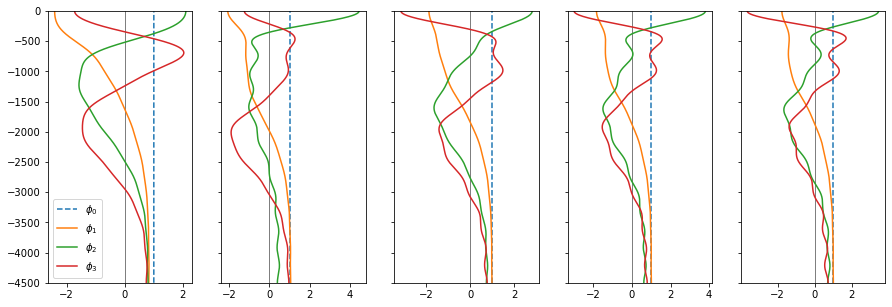

In [43]:
fig,ax = plt.subplots(ncols=5,figsize=[15,5],sharey=True)
ax[0].axvline(0,color='k',linewidth=0.5)
ax[0].plot(truth_N2profiles.phi_n.isel(loc=0,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=0,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=0,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=0,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax[0].set_ylim(-4500,0)
ax[0].legend()

ax[1].axvline(0,color='k',linewidth=0.5)
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax[1].set_ylim(-4500,0)

ax[2].axvline(0,color='k',linewidth=0.5)
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax[2].set_ylim(-4500,0)

ax[3].axvline(0,color='k',linewidth=0.5)
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax[3].set_ylim(-4500,0)

ax[4].axvline(0,color='k',linewidth=0.5)
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax[4].set_ylim(-4500,0)

# SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3).plot(ax=ax[0],y='depth_i')

(-4500.0, 0.0)

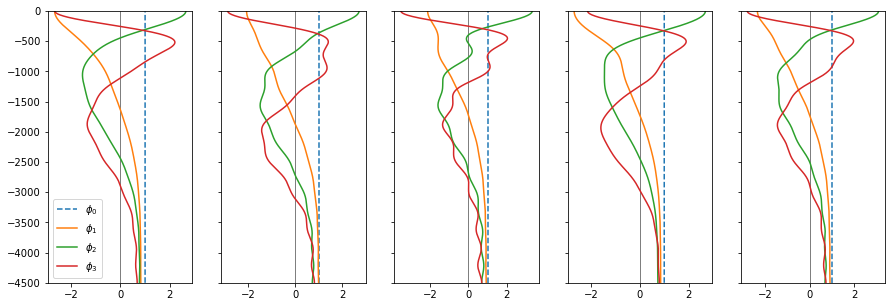

In [44]:
fig,ax = plt.subplots(ncols=5,figsize=[15,5],sharey=True)
ax[0].axvline(0,color='k',linewidth=0.5)
ax[0].plot(truth_N2profiles.phi_n.isel(loc=1,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=1,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=1,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax[0].plot(truth_N2profiles.phi_n.isel(loc=1,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax[0].set_ylim(-4500,0)
ax[0].legend()
ax[1].axvline(0,color='k',linewidth=0.5)
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax[1].plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax[1].set_ylim(-4500,0)
ax[2].axvline(0,color='k',linewidth=0.5)
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax[2].plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax[2].set_ylim(-4500,0)
ax[3].axvline(0,color='k',linewidth=0.5)
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax[3].plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax[3].set_ylim(-4500,0)
ax[4].axvline(0,color='k',linewidth=0.5)
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax[4].plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax[4].set_ylim(-4500,0)
# SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3).plot(ax=ax[0],y='depth_i')

Text(0.5, 0, 'Normalised mode amplitude')

<Figure size 432x288 with 0 Axes>

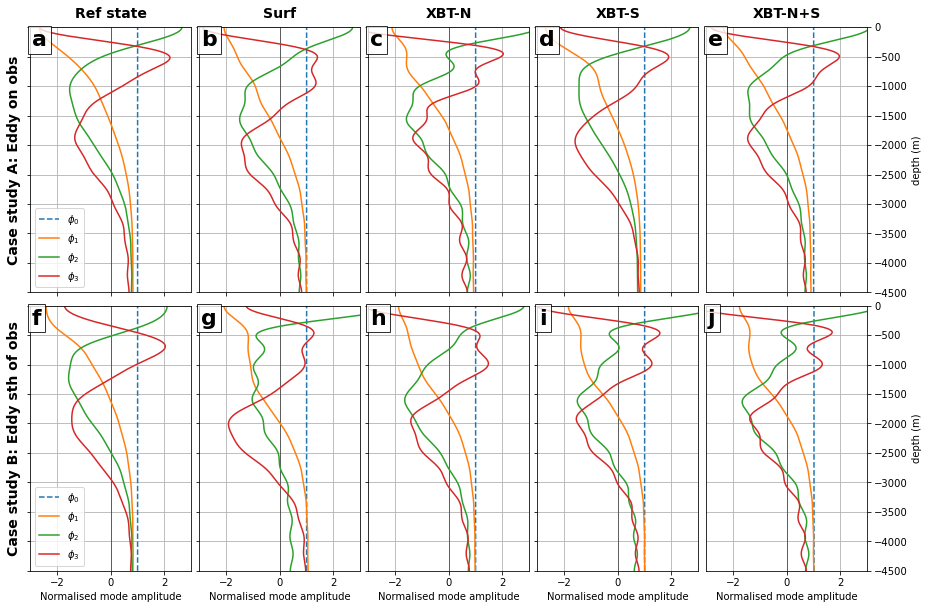

In [45]:

gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.1, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,2])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,3])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,4])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_xticklabels('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel('depth (m)')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,0])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.legend()
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.text(-.1, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,1])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,2])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,3])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,4])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel('depth (m)')
ax.grid()
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')

In [ ]:

gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax.plot(truth_N2profiles.phi_n.isel(loc=1,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.1, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,2])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,3])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax = fig.add_subplot(gs[0,4])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_xticklabels('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel('depth (m)')
ax.grid()
ax.set_xlim(-3,3)
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,0])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=0),truth_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=1),truth_N2profiles.depth_i,label='$\phi_1$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=2),truth_N2profiles.depth_i,label='$\phi_2$')
ax.plot(truth_N2profiles.phi_n.isel(loc=0,Mode=3),truth_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.legend()
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.text(-.1, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,1])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,2])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.set_yticklabels('')
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,3])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_S_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_S_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_yticklabels('')
ax.grid()
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')
ax = fig.add_subplot(gs[1,4])
ax.axvline(0,color='k',linewidth=0.5)
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=0),SSHSST_XBT_N2profiles.depth_i,linestyle='--',label='$\phi_0$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=1),SSHSST_XBT_N2profiles.depth_i,label='$\phi_1$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=2),SSHSST_XBT_N2profiles.depth_i,label='$\phi_2$')
ax.plot(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=3),SSHSST_XBT_N2profiles.depth_i,label='$\phi_3$')
ax.set_ylim(-4500,0)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel('depth (m)')
ax.grid()
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_xlim(-3,3)
ax.set_xlabel('Normalised mode amplitude')

In [46]:
def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


In [47]:
SSHSST_eddy3

<xarray.Dataset>
Dimensions:      (ocean_time: 2, s_rho: 30, eta_rho: 317, xi_rho: 272, s_w: 31)
Coordinates:
    z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.492 -1.044
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time   (ocean_time) datetime64[ns] 2012-03-11 2012-03-16
    z_rho        (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -0.9978
  * s_w          (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 25.2
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 35.53
    zeta         (ocean_time, eta_rho, xi_rho) float64 nan nan ... 0.524 0.524
    dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    dz0          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
    z_w0         (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4779 0.4779
Attributes: (12/39)
    file:              roms_fwd_outer1.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.1.0/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Wednesday - September 1, 2021 ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADJOINT, ADJUST_BOUNDARY, ADJUST_STFLUX, ADJUST_W...

In [48]:
# truth_eddy3["rho_raw"] = rho_eos(truth_eddy3.temp,truth_eddy3.salt,truth_eddy3.z_rho)
# SSHSST_eddy3["rho_raw"] = rho_eos(SSHSST_eddy3.temp,SSHSST_eddy3.salt,SSHSST_eddy3.z_rho)
# SSHSST_XBT_N_eddy3["rho_raw"] = rho_eos(SSHSST_XBT_N_eddy3.temp,SSHSST_XBT_N_eddy3.salt,SSHSST_XBT_N_eddy3.z_rho)
# SSHSST_XBT_S_eddy3["rho_raw"] = rho_eos(SSHSST_XBT_S_eddy3.temp,SSHSST_XBT_S_eddy3.salt,SSHSST_XBT_S_eddy3.z_rho)
# SSHSST_XBT_eddy3["rho_raw"] = rho_eos(SSHSST_XBT_eddy3.temp,SSHSST_XBT_eddy3.salt,SSHSST_XBT_eddy3.z_rho)


In [49]:
# calculate long term mean velocities.

#  subset in time
time_range_to_load_full2012 = slice('2012-01-01','2013-01-01')

truth_2012 = truth.sel(ocean_time=time_range_to_load_full2012)
SSHSST_2012 = OSSE_SSHSST.sel(ocean_time=time_range_to_load_full2012)
SSHSST_XBT_N_2012 = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_full2012)
SSHSST_XBT_S_2012 = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_full2012)
SSHSST_XBT_2012 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_full2012)

#  dump a whole bunch of variables
VarToKeep = ['u_eastward','v_northward']
truth_2012,dump = process_trimVarsROMS(truth_2012,VarToKeep)
SSHSST_2012,dump = process_trimVarsROMS(SSHSST_2012,VarToKeep)
SSHSST_XBT_N_2012,dump = process_trimVarsROMS(SSHSST_XBT_N_2012,VarToKeep)
SSHSST_XBT_S_2012,dump = process_trimVarsROMS(SSHSST_XBT_S_2012,VarToKeep)
SSHSST_XBT_2012,dump = process_trimVarsROMS(SSHSST_XBT_2012,VarToKeep)

print('processed data')
# truth_2012.load()
truth_2012["u_mean"] = truth_2012.u_eastward.mean(dim='ocean_time')
truth_2012["v_mean"] = truth_2012.v_northward.mean(dim='ocean_time')
truth_2012=truth_2012.drop_vars(['u_eastward','v_northward'])
print('made truth rho mean.')

SSHSST_2012["u_mean"] = SSHSST_2012.u_eastward.mean(dim='ocean_time')
SSHSST_2012["v_mean"] = SSHSST_2012.v_northward.mean(dim='ocean_time')
SSHSST_2012=SSHSST_2012.drop_vars(['u_eastward','v_northward'])

print('made sshsst rho mean.')
SSHSST_XBT_N_2012["u_mean"] = SSHSST_XBT_N_2012.u_eastward.mean(dim='ocean_time')
SSHSST_XBT_N_2012["v_mean"] = SSHSST_XBT_N_2012.v_northward.mean(dim='ocean_time')
SSHSST_XBT_N_2012=SSHSST_XBT_N_2012.drop_vars(['u_eastward','v_northward'])

print('made xbt-n rho mean.')
SSHSST_XBT_S_2012["u_mean"] = SSHSST_XBT_S_2012.u_eastward.mean(dim='ocean_time')
SSHSST_XBT_S_2012["v_mean"] = SSHSST_XBT_S_2012.v_northward.mean(dim='ocean_time')
SSHSST_XBT_S_2012=SSHSST_XBT_S_2012.drop_vars(['u_eastward','v_northward'])
print('made xbt-s rho mean.')

SSHSST_XBT_2012["u_mean"] = SSHSST_XBT_2012.u_eastward.mean(dim='ocean_time')
SSHSST_XBT_2012["v_mean"] = SSHSST_XBT_2012.v_northward.mean(dim='ocean_time')
SSHSST_XBT_2012=SSHSST_XBT_2012.drop_vars(['u_eastward','v_northward'])




# truth_2012 = xr.load_dataset('truth_2012_rhoMean.nc')
# SSHSST_2012 = xr.load_dataset('SSHSST_2012_rhoMean.nc')
# SSHSST_XBT_N_2012 = xr.load_dataset('SSHSST_XBT_N_2012_rhoMean.nc')
# SSHSST_XBT_S_2012 = xr.load_dataset('SSHSST_XBT_S_2012_rhoMean.nc')
# SSHSST_XBT_2012 = xr.load_dataset('SSHSST_XBT_2012_rhoMean.nc')



processed data
made truth rho mean.
made sshsst rho mean.
made xbt-n rho mean.
made xbt-s rho mean.


In [50]:

# subtract the 2012 mean value to give the density anomaly from the mean.
truth_eddy3["u_anom"] = truth_eddy3.u_eastward - truth_2012.u_mean
SSHSST_eddy3["u_anom"] = SSHSST_eddy3.u_eastward - SSHSST_2012.u_mean
SSHSST_XBT_N_eddy3["u_anom"] = SSHSST_XBT_N_eddy3.u_eastward - SSHSST_XBT_N_2012.u_mean
SSHSST_XBT_S_eddy3["u_anom"] = SSHSST_XBT_S_eddy3.u_eastward - SSHSST_XBT_S_2012.u_mean
SSHSST_XBT_eddy3["u_anom"] = SSHSST_XBT_eddy3.u_eastward - SSHSST_XBT_2012.u_mean

truth_eddy3["v_anom"] = truth_eddy3.v_northward - truth_2012.v_mean
SSHSST_eddy3["v_anom"] = SSHSST_eddy3.v_northward - SSHSST_2012.v_mean
SSHSST_XBT_N_eddy3["v_anom"] = SSHSST_XBT_N_eddy3.v_northward - SSHSST_XBT_N_2012.v_mean
SSHSST_XBT_S_eddy3["v_anom"] = SSHSST_XBT_S_eddy3.v_northward - SSHSST_XBT_S_2012.v_mean
SSHSST_XBT_eddy3["v_anom"] = SSHSST_XBT_eddy3.v_northward - SSHSST_XBT_2012.v_mean


In [51]:
truth_eddy3.u_anom.mean(dim='ocean_time')


<xarray.DataArray 'u_anom' (s_rho: 30, eta_rho: 317, xi_rho: 272)>
array([[[        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ..., -0.00840811,
         -0.00854613,  0.        ],
        [        nan,         nan,         nan, ..., -0.00715688,
         -0.01002927,  0.        ],
        ...,
        [        nan,         nan,         nan, ..., -0.0136129 ,
         -0.03920739,  0.        ],
        [        nan,         nan,         nan, ..., -0.02021395,
         -0.04293366,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ..., -0.00973161,
         -0.00729988,  0.        ],
        [        nan,         nan,         nan, ..., -0.00834258,
         -0.00935347,  0.        ],
...
        [        nan,         nan,         nan, ...,  0.27578292,
          0.22730605,  0.        ],
        [        nan,         nan,         nan, ...,  0.25596704,
          0.21137967,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,  0.00318128,
          0.00426865,  0.        ],
        [        nan,         nan,         nan, ..., -0.01433923,
         -0.01191383,  0.        ],
        ...,
        [        nan,         nan,         nan, ...,  0.26195205,
          0.21701516,  0.        ],
        [        nan,         nan,         nan, ...,  0.2438907 ,
          0.20123795,  0.        ],
        [        nan,         nan,         nan, ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    z_rho0   (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.483 -1.035
  * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
Dimensions without coordinates: eta_rho, xi_rho

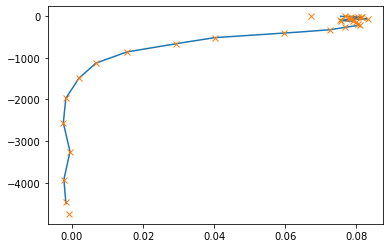

In [52]:
# interpolate those rho values to the same depths as the normal modes
interp_to_array = np.arange(-4500,0,5)

#loc 0 - south
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=123).values,truth_eddy3.u_anom.isel(eta_rho=60,xi_rho=123).mean(dim='ocean_time').values)
truth_eddy3_SthReg_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=40,xi_rho=140).values,SSHSST_eddy3.u_anom.isel(eta_rho=40,xi_rho=140).mean(dim='ocean_time').values)
SSHSST_eddy3_SthReg_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=55,xi_rho=128).values,SSHSST_XBT_N_eddy3.u_anom.isel(eta_rho=55,xi_rho=128).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_SthReg_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=53,xi_rho=128).values,SSHSST_XBT_S_eddy3.u_anom.isel(eta_rho=53,xi_rho=128).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_SthReg_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=35,xi_rho=140).values,SSHSST_XBT_eddy3.u_anom.isel(eta_rho=35,xi_rho=140).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_SthReg_u_i = (ii(interp_to_array)).T


#loc 1 - on obs/high E region
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=120,xi_rho=155).values,truth_eddy3.u_anom.isel(eta_rho=120,xi_rho=155).mean(dim='ocean_time').values)
truth_eddy3_highE_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=115,xi_rho=165).values,SSHSST_eddy3.u_anom.isel(eta_rho=115,xi_rho=165).mean(dim='ocean_time').values)
SSHSST_eddy3_highE_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=115,xi_rho=160).values,SSHSST_XBT_N_eddy3.u_anom.isel(eta_rho=115,xi_rho=160).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_highE_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=115,xi_rho=157).values,SSHSST_XBT_S_eddy3.u_anom.isel(eta_rho=115,xi_rho=157).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_highE_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=110,xi_rho=158).values,SSHSST_XBT_eddy3.u_anom.isel(eta_rho=110,xi_rho=158).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_highE_u_i = (ii(interp_to_array)).T


#loc 2 - south-fareast
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=240).values,truth_eddy3.u_anom.isel(eta_rho=60,xi_rho=240).mean(dim='ocean_time').values)
truth_eddy3_SthRegFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=40,xi_rho=240).values,SSHSST_eddy3.u_anom.isel(eta_rho=40,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_eddy3_SthRegFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=55,xi_rho=240).values,SSHSST_XBT_N_eddy3.u_anom.isel(eta_rho=55,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_SthRegFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=53,xi_rho=240).values,SSHSST_XBT_S_eddy3.u_anom.isel(eta_rho=53,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_SthRegFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=35,xi_rho=240).values,SSHSST_XBT_eddy3.u_anom.isel(eta_rho=35,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_SthRegFarEast_u_i = (ii(interp_to_array)).T


#loc 3 - on obs/high E region-fareast
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=120,xi_rho=240).values,truth_eddy3.u_anom.isel(eta_rho=120,xi_rho=240).mean(dim='ocean_time').values)
truth_eddy3_highEFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_eddy3.u_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_eddy3_highEFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_XBT_N_eddy3.u_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_highEFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_XBT_S_eddy3.u_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_highEFarEast_u_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=110,xi_rho=240).values,SSHSST_XBT_eddy3.u_anom.isel(eta_rho=110,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_highEFarEast_u_i = (ii(interp_to_array)).T

plt.plot(truth_eddy3_SthReg_u_i,interp_to_array)
plt.plot(truth_eddy3.u_anom.isel(eta_rho=60,xi_rho=123).mean(dim='ocean_time').values,truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=123).values,marker='x',linestyle='none')


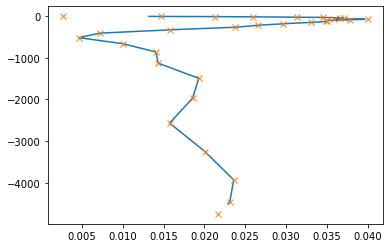

In [53]:
# interpolate those rho values to the same depths as the normal modes
interp_to_array = np.arange(-4500,0,5)

#loc 0 - south
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=123).values,truth_eddy3.v_anom.isel(eta_rho=60,xi_rho=123).mean(dim='ocean_time').values)
truth_eddy3_SthReg_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=40,xi_rho=140).values,SSHSST_eddy3.v_anom.isel(eta_rho=40,xi_rho=140).mean(dim='ocean_time').values)
SSHSST_eddy3_SthReg_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=55,xi_rho=128).values,SSHSST_XBT_N_eddy3.v_anom.isel(eta_rho=55,xi_rho=128).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_SthReg_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=53,xi_rho=128).values,SSHSST_XBT_S_eddy3.v_anom.isel(eta_rho=53,xi_rho=128).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_SthReg_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=35,xi_rho=140).values,SSHSST_XBT_eddy3.v_anom.isel(eta_rho=35,xi_rho=140).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_SthReg_v_i = (ii(interp_to_array)).T


#loc 1 - on obs/high E region
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=120,xi_rho=155).values,truth_eddy3.v_anom.isel(eta_rho=120,xi_rho=155).mean(dim='ocean_time').values)
truth_eddy3_highE_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=115,xi_rho=165).values,SSHSST_eddy3.v_anom.isel(eta_rho=115,xi_rho=165).mean(dim='ocean_time').values)
SSHSST_eddy3_highE_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=115,xi_rho=160).values,SSHSST_XBT_N_eddy3.v_anom.isel(eta_rho=115,xi_rho=160).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_highE_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=115,xi_rho=157).values,SSHSST_XBT_S_eddy3.v_anom.isel(eta_rho=115,xi_rho=157).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_highE_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=110,xi_rho=158).values,SSHSST_XBT_eddy3.v_anom.isel(eta_rho=110,xi_rho=158).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_highE_v_i = (ii(interp_to_array)).T


#loc 2 - south-fareast
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=240).values,truth_eddy3.v_anom.isel(eta_rho=60,xi_rho=240).mean(dim='ocean_time').values)
truth_eddy3_SthRegFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=40,xi_rho=240).values,SSHSST_eddy3.v_anom.isel(eta_rho=40,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_eddy3_SthRegFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=55,xi_rho=240).values,SSHSST_XBT_N_eddy3.v_anom.isel(eta_rho=55,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_SthRegFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=53,xi_rho=240).values,SSHSST_XBT_S_eddy3.v_anom.isel(eta_rho=53,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_SthRegFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=35,xi_rho=240).values,SSHSST_XBT_eddy3.v_anom.isel(eta_rho=35,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_SthRegFarEast_v_i = (ii(interp_to_array)).T


#loc 3 - on obs/high E region-fareast
ii = interpolate.interp1d(truth_eddy3.z_rho0.isel(eta_rho=120,xi_rho=240).values,truth_eddy3.v_anom.isel(eta_rho=120,xi_rho=240).mean(dim='ocean_time').values)
truth_eddy3_highEFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_eddy3.v_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_eddy3_highEFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_N_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_XBT_N_eddy3.v_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_N_eddy3_highEFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_S_eddy3.z_rho0.isel(eta_rho=115,xi_rho=240).values,SSHSST_XBT_S_eddy3.v_anom.isel(eta_rho=115,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_S_eddy3_highEFarEast_v_i = (ii(interp_to_array)).T

ii = interpolate.interp1d(SSHSST_XBT_eddy3.z_rho0.isel(eta_rho=110,xi_rho=240).values,SSHSST_XBT_eddy3.v_anom.isel(eta_rho=110,xi_rho=240).mean(dim='ocean_time').values)
SSHSST_XBT_eddy3_highEFarEast_v_i = (ii(interp_to_array)).T

plt.plot(truth_eddy3_SthReg_v_i,interp_to_array)
plt.plot(truth_eddy3.v_anom.isel(eta_rho=60,xi_rho=123).mean(dim='ocean_time').values,truth_eddy3.z_rho0.isel(eta_rho=60,xi_rho=123).values,marker='x',linestyle='none')


In [54]:
# # project onto rho profile - first location
# print('    truth rho dot mode')
# for nn in truth_N2profiles.Mode:
#     # print(nn)
#     print((1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_SthReg_rho_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)

# print('   Surf rho dot mode')
# for nn in SSHSST_N2profiles.Mode:
#     # print(nn)
#     print((1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_SthReg_rho_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)

# print('   XBT-N rho dot mode')
# for nn in SSHSST_XBT_N_N2profiles.Mode:
#     # print(nn)
#     print((1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_SthReg_rho_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)

# print('   XBT-S rho dot mode')
# for nn in SSHSST_XBT_S_N2profiles.Mode:
#     # print(nn)
#     print((1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_SthReg_rho_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)

# print('   XBT-N+S rho dot mode')
# for nn in SSHSST_XBT_N2profiles.Mode:
#     # print(nn)
#     print((1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_SthReg_rho_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)


In [55]:
expNames=['truth','SSHSST','SSHSST_XBT_N','SSHSST_XBT_S','SSHSST_XBT']
modes = truth_N2profiles.Mode
truth_mode_proj_SthReg_u = []
SSHSST_mode_proj_SthReg_u = []
SSHSST_XBT_N_mode_proj_SthReg_u = []
SSHSST_XBT_S_mode_proj_SthReg_u = []
SSHSST_XBT_mode_proj_SthReg_u = []

# KE'_n = 1/2H * (u'_n^2 + v'_n^2)

# # project onto rho profile
print('   truth rho dot mode')
for nn in truth_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
    # truth_mode_proj_SthReg_u.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_SthReg_u_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))
    u_squared = np.sum(truth_eddy3_SthReg_u_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    v_squared = np.sum(truth_eddy3_SthReg_v_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    truth_mode_proj_SthReg_u.append( front_factor*(u_squared + v_squared) )

print('   Surf rho dot mode')
for nn in SSHSST_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
    # SSHSST_mode_proj_SthReg_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_SthReg_u_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_eddy3_SthReg_u_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_eddy3_SthReg_v_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    SSHSST_mode_proj_SthReg_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-N rho dot mode')
for nn in SSHSST_XBT_N_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_N_mode_proj_SthReg_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_SthReg_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_N_eddy3_SthReg_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_N_eddy3_SthReg_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    SSHSST_XBT_N_mode_proj_SthReg_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-S rho dot mode')
for nn in SSHSST_XBT_S_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_S_mode_proj_SthReg_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_SthReg_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_S_eddy3_SthReg_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_S_eddy3_SthReg_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    SSHSST_XBT_S_mode_proj_SthReg_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-N+S rho dot mode')
for nn in SSHSST_XBT_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_mode_proj_SthReg_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_SthReg_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_eddy3_SthReg_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_eddy3_SthReg_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    SSHSST_XBT_mode_proj_SthReg_u.append( front_factor*(u_squared + v_squared) )
                    
truth_mode_proj_highE_u = []
SSHSST_mode_proj_highE_u = []
SSHSST_XBT_N_mode_proj_highE_u = []
SSHSST_XBT_S_mode_proj_highE_u = []
SSHSST_XBT_mode_proj_highE_u = []

# highekeregion
print('   truth rho dot mode')
for nn in truth_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
    # truth_mode_proj_highE_u.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_highE_u_i*truth_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))
    u_squared = np.sum(truth_eddy3_highE_u_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    v_squared = np.sum(truth_eddy3_highE_v_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    truth_mode_proj_highE_u.append( front_factor*(u_squared + v_squared) )

print('   Surf rho dot mode')
for nn in SSHSST_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
    # SSHSST_mode_proj_highE_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_highE_u_i*SSHSST_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_eddy3_highE_u_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_eddy3_highE_v_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    SSHSST_mode_proj_highE_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-N rho dot mode')
for nn in SSHSST_XBT_N_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_N_mode_proj_highE_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_highE_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_N_eddy3_highE_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_N_eddy3_highE_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    SSHSST_XBT_N_mode_proj_highE_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-S rho dot mode')
for nn in SSHSST_XBT_S_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_S_mode_proj_highE_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_highE_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_S_eddy3_highE_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_S_eddy3_highE_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    SSHSST_XBT_S_mode_proj_highE_u.append( front_factor*(u_squared + v_squared) )
                    
print('   XBT-N+S rho dot mode')
for nn in SSHSST_XBT_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_mode_proj_highE_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_highE_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_eddy3_highE_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_eddy3_highE_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    SSHSST_XBT_mode_proj_highE_u.append( front_factor*(u_squared + v_squared) )


truth_mode_proj_SthRegFarEast_u = []
SSHSST_mode_proj_SthRegFarEast_u = []
SSHSST_XBT_N_mode_proj_SthRegFarEast_u = []
SSHSST_XBT_S_mode_proj_SthRegFarEast_u = []
SSHSST_XBT_mode_proj_SthRegFarEast_u = []

# south-fareast
print('   truth rho dot mode')
for nn in truth_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
    # truth_mode_proj_SthRegFarEast_u.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_SthRegFarEast_u_i*truth_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))
    u_squared = np.sum(truth_eddy3_SthRegFarEast_u_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    v_squared = np.sum(truth_eddy3_SthRegFarEast_v_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    truth_mode_proj_SthRegFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   Surf rho dot mode')
for nn in SSHSST_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
    # SSHSST_mode_proj_SthRegFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_SthRegFarEast_u_i*SSHSST_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_eddy3_SthRegFarEast_u_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_eddy3_SthRegFarEast_v_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    SSHSST_mode_proj_SthRegFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-N rho dot mode')
for nn in SSHSST_XBT_N_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_N_mode_proj_SthRegFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_SthRegFarEast_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_N_eddy3_SthRegFarEast_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_N_eddy3_SthRegFarEast_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    SSHSST_XBT_N_mode_proj_SthRegFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-S rho dot mode')
for nn in SSHSST_XBT_S_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_S_mode_proj_SthRegFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_SthRegFarEast_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_S_eddy3_SthRegFarEast_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_S_eddy3_SthRegFarEast_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    SSHSST_XBT_S_mode_proj_SthRegFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-N+S rho dot mode')
for nn in SSHSST_XBT_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_mode_proj_SthRegFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_SthRegFarEast_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_eddy3_SthRegFarEast_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_eddy3_SthRegFarEast_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    SSHSST_XBT_mode_proj_SthRegFarEast_u.append( front_factor*(u_squared + v_squared) )
    
truth_mode_proj_highEFarEast_u = []
SSHSST_mode_proj_highEFarEast_u = []
SSHSST_XBT_N_mode_proj_highEFarEast_u = []
SSHSST_XBT_S_mode_proj_highEFarEast_u = []
SSHSST_XBT_mode_proj_highEFarEast_u = []

# highekeregion-fareast
print('   truth rho dot mode')
for nn in truth_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
    # truth_mode_proj_highEFarEast_u.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_highEFarEast_u_i*truth_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))
    u_squared = np.sum(truth_eddy3_highEFarEast_u_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    v_squared = np.sum(truth_eddy3_highEFarEast_v_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))**2
    truth_mode_proj_highEFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   Surf rho dot mode')
for nn in SSHSST_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
    # SSHSST_mode_proj_highEFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_highEFarEast_u_i*SSHSST_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_eddy3_highEFarEast_u_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_eddy3_highEFarEast_v_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))**2
    SSHSST_mode_proj_highEFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-N rho dot mode')
for nn in SSHSST_XBT_N_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_N_mode_proj_highEFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_highEFarEast_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_N_eddy3_highEFarEast_u_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_N_eddy3_highEFarEast_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))**2
    SSHSST_XBT_N_mode_proj_highEFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-S rho dot mode')
for nn in SSHSST_XBT_S_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_S_mode_proj_highEFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_highEFarEast_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_S_eddy3_highEFarEast_u_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_S_eddy3_highEFarEast_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))**2
    SSHSST_XBT_S_mode_proj_highEFarEast_u.append( front_factor*(u_squared + v_squared) )
    
print('   XBT-N+S rho dot mode')
for nn in SSHSST_XBT_N2profiles.Mode.values:
    # normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
    # SSHSST_XBT_mode_proj_highEFarEast_u.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_highEFarEast_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)
    front_factor = 1/(2*np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))
    u_squared = np.sum(SSHSST_XBT_eddy3_highEFarEast_u_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    v_squared = np.sum(SSHSST_XBT_eddy3_highEFarEast_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))**2
    SSHSST_XBT_mode_proj_highEFarEast_u.append( front_factor*(u_squared + v_squared) )
    

   truth rho dot mode
   Surf rho dot mode
   XBT-N rho dot mode
   XBT-S rho dot mode
   XBT-N+S rho dot mode
   truth rho dot mode
   Surf rho dot mode
   XBT-N rho dot mode
   XBT-S rho dot mode
   XBT-N+S rho dot mode
   truth rho dot mode
   Surf rho dot mode
   XBT-N rho dot mode
   XBT-S rho dot mode
   XBT-N+S rho dot mode
   truth rho dot mode
   Surf rho dot mode
   XBT-N rho dot mode
   XBT-S rho dot mode
   XBT-N+S rho dot mode


In [56]:
# expNames=['truth','SSHSST','SSHSST_XBT_N','SSHSST_XBT_S','SSHSST_XBT']
# modes = truth_N2profiles.Mode
# truth_mode_proj_SthReg_v = []
# SSHSST_mode_proj_SthReg_v = []
# SSHSST_XBT_N_mode_proj_SthReg_v = []
# SSHSST_XBT_S_mode_proj_SthReg_v = []
# SSHSST_XBT_mode_proj_SthReg_v = []

# # # project onto rho profile
# print('   truth rho dot mode')
# for nn in truth_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
#     truth_mode_proj_SthReg_v.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_SthReg_v_i*truth_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)

# print('   Surf rho dot mode')
# for nn in SSHSST_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
#     SSHSST_mode_proj_SthReg_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_SthReg_v_i*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N rho dot mode')
# for nn in SSHSST_XBT_N_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_N_mode_proj_SthReg_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_SthReg_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-S rho dot mode')
# for nn in SSHSST_XBT_S_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_S_mode_proj_SthReg_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_SthReg_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N+S rho dot mode')
# for nn in SSHSST_XBT_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_mode_proj_SthReg_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_SthReg_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)

# truth_mode_proj_highE_v = []
# SSHSST_mode_proj_highE_v = []
# SSHSST_XBT_N_mode_proj_highE_v = []
# SSHSST_XBT_S_mode_proj_highE_v = []
# SSHSST_XBT_mode_proj_highE_v = []

# # highekeregion
# print('   truth rho dot mode')
# for nn in truth_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
#     truth_mode_proj_highE_v.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_highE_v_i*truth_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)

# print('   Surf rho dot mode')
# for nn in SSHSST_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
#     SSHSST_mode_proj_highE_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_highE_v_i*SSHSST_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N rho dot mode')
# for nn in SSHSST_XBT_N_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_N_mode_proj_highE_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_highE_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-S rho dot mode')
# for nn in SSHSST_XBT_S_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_S_mode_proj_highE_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_highE_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N+S rho dot mode')
# for nn in SSHSST_XBT_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_mode_proj_highE_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_highE_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=1,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)



# truth_mode_proj_SthRegFarEast_v = []
# SSHSST_mode_proj_SthRegFarEast_v = []
# SSHSST_XBT_N_mode_proj_SthRegFarEast_v = []
# SSHSST_XBT_S_mode_proj_SthRegFarEast_v = []
# SSHSST_XBT_mode_proj_SthRegFarEast_v = []

# # south-fareast
# print('   truth rho dot mode')
# for nn in truth_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
#     truth_mode_proj_SthRegFarEast_v.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_SthRegFarEast_v_i*truth_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)

# print('   Surf rho dot mode')
# for nn in SSHSST_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
#     SSHSST_mode_proj_SthRegFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_SthRegFarEast_v_i*SSHSST_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N rho dot mode')
# for nn in SSHSST_XBT_N_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_N_mode_proj_SthRegFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_SthRegFarEast_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-S rho dot mode')
# for nn in SSHSST_XBT_S_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_S_mode_proj_SthRegFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_SthRegFarEast_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N+S rho dot mode')
# for nn in SSHSST_XBT_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=2,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_mode_proj_SthRegFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_SthRegFarEast_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=2,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)

# truth_mode_proj_highEFarEast_v = []
# SSHSST_mode_proj_highEFarEast_v = []
# SSHSST_XBT_N_mode_proj_highEFarEast_v = []
# SSHSST_XBT_S_mode_proj_highEFarEast_v = []
# SSHSST_XBT_mode_proj_highEFarEast_v = []

# # highekeregion-fareast
# print('   truth rho dot mode')
# for nn in truth_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0]))).values
#     truth_mode_proj_highEFarEast_v.append( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_eddy3_highEFarEast_v_i*truth_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values/normFac)

# print('   Surf rho dot mode')
# for nn in SSHSST_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))).values
#     SSHSST_mode_proj_highEFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_eddy3_highEFarEast_v_i*SSHSST_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N rho dot mode')
# for nn in SSHSST_XBT_N_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_N_mode_proj_highEFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_eddy3_highEFarEast_v_i*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-S rho dot mode')
# for nn in SSHSST_XBT_S_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_S_mode_proj_highEFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_eddy3_highEFarEast_v_i*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values/normFac)

# print('   XBT-N+S rho dot mode')
# for nn in SSHSST_XBT_N2profiles.Mode.values:
#     normFac = 1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))).values
#     SSHSST_XBT_mode_proj_highEFarEast_v.append( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_eddy3_highEFarEast_v_i*SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=nn)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values/normFac)


<Figure size 432x288 with 0 Axes>

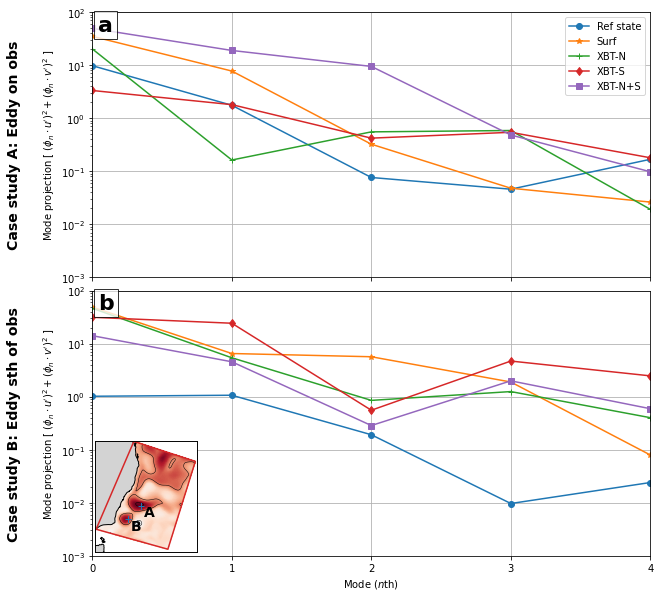

In [57]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(np.array(truth_mode_proj_highE_u)           ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_highE_u)            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_highE_u),marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_highE_u),marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_highE_u)    ,marker='s',label='XBT-N+S')
ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_ylim([1e-3, 1e2])
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.set_xlim([0,4])
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(np.array(truth_mode_proj_SthReg_u)              ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_SthReg_u)            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_SthReg_u),marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_SthReg_u),marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_SthReg_u)    ,marker='s',label='XBT-N+S')
ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_xlabel('Mode ($n$th)')
ax.set_xlim([0,4])
ax.set_xticks([0,1,2,3,4])
ax.grid()
ax.set_ylim([1e-3, 1e2])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

axins = fig.add_axes([.11, 0.13, 0.18, 0.155], projection=ccrs.PlateCarree())

# axins = fig.add_axes([.71, 0.33, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
# axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

/local/m68/deg581/tmp/ipykernel_3458928/2359649130.py:89: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

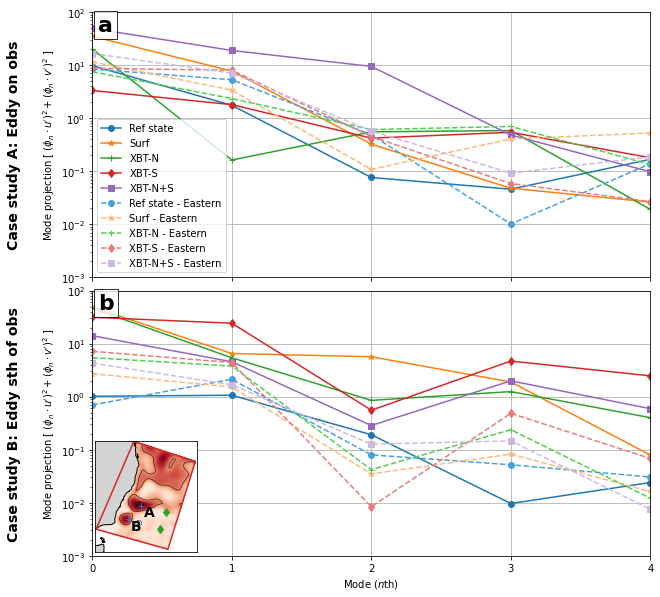

In [58]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(np.array(truth_mode_proj_highE_u)           ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_highE_u)            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_highE_u),marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_highE_u),marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_highE_u)    ,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_highEFarEast_u,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_highEFarEast_u,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_highEFarEast_u,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_highEFarEast_u,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_highEFarEast_u,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_ylim([1e-3, 1e2])
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.set_xlim([0,4])
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(np.array(truth_mode_proj_SthReg_u)              ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_SthReg_u)            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_SthReg_u),marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_SthReg_u),marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_SthReg_u)    ,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_SthRegFarEast_u,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_SthRegFarEast_u,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_SthRegFarEast_u,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_SthRegFarEast_u,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_SthRegFarEast_u,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_xlabel('Mode ($n$th)')
ax.set_xlim([0,4])
ax.set_ylim([1e-3, 1e2])
ax.set_xticks([0,1,2,3,4])
ax.grid()
# ax.legend()
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)



axins = fig.add_axes([.11, 0.13, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.plot(157.7,-35.9,marker='d',color='C2')
axins.plot(156.8,-38.4,marker='d',color='C2')

axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [59]:
STOP

NameError: name 'STOP' is not defined

In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(np.array(truth_mode_proj_SthReg_u)**2+np.array(truth_mode_proj_SthReg_v)**2,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_SthReg_u)**2+np.array(SSHSST_mode_proj_SthReg_v)**2,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_N_mode_proj_SthReg_v)**2,marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_S_mode_proj_SthReg_v)**2,marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_mode_proj_SthReg_v)**2,marker='s',label='XBT-N+S')
ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.set_xlim([0,4])
ax.grid()
ax.legend()

In [ ]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(np.array(truth_mode_proj_highE_u)**2+np.array(truth_mode_proj_highE_v)**2              ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_highE_u)**2+np.array(SSHSST_mode_proj_highE_v)**2            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_highE_u)**2+np.array(SSHSST_XBT_N_mode_proj_highE_v)**2,marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_highE_u)**2+np.array(SSHSST_XBT_S_mode_proj_highE_v)**2,marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_highE_u)**2+np.array(SSHSST_XBT_mode_proj_highE_v)**2    ,marker='s',label='XBT-N+S')
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
# ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.set_xlim([0,4])
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(np.array(truth_mode_proj_SthReg_u)**2+np.array(truth_mode_proj_SthReg_v)**2              ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_SthReg_u)**2+np.array(SSHSST_mode_proj_SthReg_v)**2            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_N_mode_proj_SthReg_v)**2,marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_S_mode_proj_SthReg_v)**2,marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_SthReg_u)**2+np.array(SSHSST_XBT_mode_proj_SthReg_v)**2    ,marker='s',label='XBT-N+S')
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection [ $(\phi_n\cdot u^\prime)^2+(\phi_n\cdot v^\prime)^2$ ]')
ax.set_xlabel('Mode ($n$th)')
ax.set_xlim([0,4])
ax.set_xticks([0,1,2,3,4])
ax.grid()
# ax.legend()
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.14, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


axins = fig.add_axes([.71, 0.33, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
# axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [ ]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(np.array(truth_mode_proj_highE_u)**2+np.array(truth_mode_proj_highE_v)**2              ,marker='o',label='Ref state')
ax.plot(np.array(SSHSST_mode_proj_highE_u)**2+np.array(SSHSST_mode_proj_highE_v)**2            ,marker='*',label='Surf')
ax.plot(np.array(SSHSST_XBT_N_mode_proj_highE_u)**2+np.array(SSHSST_XBT_N_mode_proj_highE_v)**2,marker='+',label='XBT-N')
ax.plot(np.array(SSHSST_XBT_S_mode_proj_highE_u)**2+np.array(SSHSST_XBT_S_mode_proj_highE_v)**2,marker='d',label='XBT-S')
ax.plot(np.array(SSHSST_XBT_mode_proj_highE_u)**2+np.array(SSHSST_XBT_mode_proj_highE_v)**2    ,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_highEFarEast,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_highEFarEast,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_highEFarEast,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_highEFarEast,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_highEFarEast,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
ax.set_xlim(.8,4.2)
ax.set_ylim(-.15,.4)
# ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(truth_mode_proj_SthReg,marker='o',label='Ref state')
ax.plot(SSHSST_mode_proj_SthReg,marker='*',label='Surf')
ax.plot(SSHSST_XBT_N_mode_proj_SthReg,marker='+',label='XBT-N')
ax.plot(SSHSST_XBT_S_mode_proj_SthReg,marker='d',label='XBT-S')
ax.plot(SSHSST_XBT_mode_proj_SthReg,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_SthRegFarEast,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_SthRegFarEast,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_SthRegFarEast,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_SthRegFarEast,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_SthRegFarEast,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
ax.set_xlim(.8,4.2)
# ax.set_ylim(.1,10)
ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.grid()
# ax.legend()
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


axins = fig.add_axes([.11, 0.13, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.plot(157.7,-35.9,marker='d',color='C2')
axins.plot(156.8,-38.4,marker='d',color='C2')

axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [ ]:
ModesToPlot=5

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(truth_mode_proj_highE[0:ModesToPlot],marker='o',label='Ref state')
ax.plot(SSHSST_mode_proj_highE[0:ModesToPlot],marker='*',label='Surf')
ax.plot(SSHSST_XBT_N_mode_proj_highE[0:ModesToPlot],marker='+',label='XBT-N')
ax.plot(SSHSST_XBT_S_mode_proj_highE[0:ModesToPlot],marker='d',label='XBT-S')
ax.plot(SSHSST_XBT_mode_proj_highE[0:ModesToPlot],marker='s',label='XBT-N+S')
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
# ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(truth_mode_proj_SthReg[0:ModesToPlot],marker='o',label='Ref state')
ax.plot(SSHSST_mode_proj_SthReg[0:ModesToPlot],marker='*',label='Surf')
ax.plot(SSHSST_XBT_N_mode_proj_SthReg[0:ModesToPlot],marker='+',label='XBT-N')
ax.plot(SSHSST_XBT_S_mode_proj_SthReg[0:ModesToPlot],marker='d',label='XBT-S')
ax.plot(SSHSST_XBT_mode_proj_SthReg[0:ModesToPlot],marker='s',label='XBT-N+S')
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.grid()
# ax.legend()
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


axins = fig.add_axes([.11, 0.13, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
# axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [ ]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
ax.plot(truth_mode_proj_highE,marker='o',label='Ref state')
ax.plot(SSHSST_mode_proj_highE,marker='*',label='Surf')
ax.plot(SSHSST_XBT_N_mode_proj_highE,marker='+',label='XBT-N')
ax.plot(SSHSST_XBT_S_mode_proj_highE,marker='d',label='XBT-S')
ax.plot(SSHSST_XBT_mode_proj_highE,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_highEFarEast,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_highEFarEast,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_highEFarEast,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_highEFarEast,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_highEFarEast,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
ax.set_xlim(.8,4.2)
ax.set_ylim(-.15,.4)
# ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels('')
ax.grid()
ax.legend()
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study A: Eddy on obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,0])
ax.plot(truth_mode_proj_SthReg,marker='o',label='Ref state')
ax.plot(SSHSST_mode_proj_SthReg,marker='*',label='Surf')
ax.plot(SSHSST_XBT_N_mode_proj_SthReg,marker='+',label='XBT-N')
ax.plot(SSHSST_XBT_S_mode_proj_SthReg,marker='d',label='XBT-S')
ax.plot(SSHSST_XBT_mode_proj_SthReg,marker='s',label='XBT-N+S')
ax.plot(truth_mode_proj_SthRegFarEast,marker='o',label='Ref state - Eastern',linestyle='--',color=adjust_lightness('C0',1.4))
ax.plot(SSHSST_mode_proj_SthRegFarEast,marker='*',label='Surf - Eastern',linestyle='--',color=adjust_lightness('C1',1.4))
ax.plot(SSHSST_XBT_N_mode_proj_SthRegFarEast,marker='+',label='XBT-N - Eastern',linestyle='--',color=adjust_lightness('C2',1.4))
ax.plot(SSHSST_XBT_S_mode_proj_SthRegFarEast,marker='d',label='XBT-S - Eastern',linestyle='--',color=adjust_lightness('C3',1.4))
ax.plot(SSHSST_XBT_mode_proj_SthRegFarEast,marker='s',label='XBT-N+S - Eastern',linestyle='--',color=adjust_lightness('C4',1.4))
# ax.set_yscale('log')
ax.set_ylabel(r'Mode projection ($\phi_n\cdot\rho(z)$)')
ax.set_xlim(.8,4.2)
# ax.set_ylim(.1,10)
ax.set_xlabel('Mode ($n$th)')
ax.set_xticks([0,1,2,3,4])
ax.grid()
# ax.legend()
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.text(-.1, .5, 'Case study B: Eddy sth of obs',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)


axins = fig.add_axes([.11, 0.13, 0.18, 0.155], projection=ccrs.PlateCarree())
axins.set_extent([147, 162.5, -42, -25])
im=truth_eddy3.zeta.mean(dim='ocean_time').plot.pcolormesh('lon_rho','lat_rho',ax=axins, add_colorbar=False, cmap='RdBu_r')
co=truth_eddy3.zeta.mean(dim='ocean_time').plot.contour('lon_rho','lat_rho',ax=axins, levels=np.arange(-2,2,.5),colors='k',linewidths=0.5)
axins.plot(153.9,-34.9,marker='+',color='C0')
axins.plot(151.9,-37,marker='+',color='C0')
axins.plot(157.7,-35.9,marker='d',color='C2')
axins.plot(156.8,-38.4,marker='d',color='C2')

axins.annotate('A', xy=(154.4,-34.9),xycoords='data',fontweight='bold',fontsize=14,va='top')
axins.annotate('B', xy=(152.4,-37.0),xycoords='data',fontweight='bold',fontsize=14,va='top')

feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

Checks on the modes

In [ ]:
# check that we're calculatating mean not mean anomaly
truth_eddy3_highEFarEast_rho_i.mean()

In [ ]:
# check normalisation

print('   what is the square of the integral of the mode?')
for nn in truth_N2profiles.Mode.values:
    print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
for nn in SSHSST_N2profiles.Mode.values:
    print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
for nn in SSHSST_XBT_N_N2profiles.Mode.values:
    print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
for nn in SSHSST_XBT_S_N2profiles.Mode.values:
    print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
for nn in SSHSST_XBT_N2profiles.Mode.values:
    print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=nn)**2*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print('.  define this as a normalisation factor for the projection above')

In [ ]:
# check orthogonality

print('   check integral of product of diff modes is equal to 0')
print('loc0')
print(' truth')
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=0)*truth_N2profiles.phi_n.isel(loc=0,Mode=1)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=1)*truth_N2profiles.phi_n.isel(loc=0,Mode=2)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=0,Mode=2)*truth_N2profiles.phi_n.isel(loc=0,Mode=3)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print(' SSHSST_N2profiles')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=0)*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=1)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=1)*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=2)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=0,Mode=2)*SSHSST_N2profiles.phi_n.isel(loc=0,Mode=3)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print(' XBT-N')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=0)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=1)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=1)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=2)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=2)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=0,Mode=3)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print(' XBT-S')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=0)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=1)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=1)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=2)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=2)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=0,Mode=3)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print(' XBT')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=0)*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=1)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=1)*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=2)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=2)*SSHSST_XBT_N2profiles.phi_n.isel(loc=0,Mode=3)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print('loc3')
print(' truth')
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=3,Mode=0)*truth_N2profiles.phi_n.isel(loc=3,Mode=1)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=3,Mode=1)*truth_N2profiles.phi_n.isel(loc=3,Mode=2)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([truth_N2profiles.depth_i,0]))))*np.sum(truth_N2profiles.phi_n.isel(loc=3,Mode=2)*truth_N2profiles.phi_n.isel(loc=3,Mode=3)*np.diff(np.hstack([truth_N2profiles.depth_i,0])))).values)
print(' SSHSST_N2profiles')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=3,Mode=0)*SSHSST_N2profiles.phi_n.isel(loc=3,Mode=1)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=3,Mode=1)*SSHSST_N2profiles.phi_n.isel(loc=3,Mode=2)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_N2profiles.depth_i,0]))))*np.sum(SSHSST_N2profiles.phi_n.isel(loc=3,Mode=2)*SSHSST_N2profiles.phi_n.isel(loc=3,Mode=3)*np.diff(np.hstack([SSHSST_N2profiles.depth_i,0])))).values)
print(' XBT-N')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=0)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=1)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=1)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=2)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=2)*SSHSST_XBT_N_N2profiles.phi_n.isel(loc=3,Mode=3)*np.diff(np.hstack([SSHSST_XBT_N_N2profiles.depth_i,0])))).values)
print(' XBT-S')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=0)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=1)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=1)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=2)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=2)*SSHSST_XBT_S_N2profiles.phi_n.isel(loc=3,Mode=3)*np.diff(np.hstack([SSHSST_XBT_S_N2profiles.depth_i,0])))).values)
print(' XBT')
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=0)*SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=1)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=1)*SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=2)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)
print( (1/(np.sum(np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0]))))*np.sum(SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=2)*SSHSST_XBT_N2profiles.phi_n.isel(loc=3,Mode=3)*np.diff(np.hstack([SSHSST_XBT_N2profiles.depth_i,0])))).values)

In [ ]:
# try reconstructing the density

test =     truth_mode_proj_SthReg[0]*truth_N2profiles.phi_n.isel(loc=0,Mode=0) + truth_mode_proj_SthReg[1]*truth_N2profiles.phi_n.isel(loc=0,Mode=1)+ truth_mode_proj_SthReg[2]*truth_N2profiles.phi_n.isel(loc=0,Mode=2) \
+ truth_mode_proj_SthReg[3]*truth_N2profiles.phi_n.isel(loc=0,Mode=3) + truth_mode_proj_SthReg[4]*truth_N2profiles.phi_n.isel(loc=0,Mode=4) + truth_mode_proj_SthReg[5]*truth_N2profiles.phi_n.isel(loc=0,Mode=5) \
+ truth_mode_proj_SthReg[6]*truth_N2profiles.phi_n.isel(loc=0,Mode=6) + truth_mode_proj_SthReg[7]*truth_N2profiles.phi_n.isel(loc=0,Mode=7) + truth_mode_proj_SthReg[8]*truth_N2profiles.phi_n.isel(loc=0,Mode=8)
plt.plot(truth_eddy3_SthReg_rho_i,interp_to_array)
plt.plot(test,interp_to_array)


#### 